<a href="https://colab.research.google.com/github/ThomasStroehle/Novelty/blob/main/novelty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novelty and Outlier Detection in idea competitions
Installation and loading of the required packages

In [1]:
%%capture
!pip install sentence-transformers
!pip install requests_html
!pip install gensim
!pip install sentence_transformers
!pip install sacremoses
!pip install simcse
!pip install openai

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')

Global variables

In [2]:
# dataset of idea contest
DATASET_FILE = "/content/drive/MyDrive/novelty/data.csv" 
# announcement text of idea contest
PRIORS_FILE = "/content/drive/MyDrive/novelty/announcement_ideas_contest.csv" 
# novelty ratings from prolific experiment
PROLIFIC_FILE = "/content/drive/MyDrive/novelty/novelty_prolific.csv"
# backup data
BACKUP_DATA_FILE = "/content/drive/MyDrive/novelty/data.pickle"
# backup prior hand
BACKUP_HAND_FILE = "/content/drive/MyDrive/novelty/prior_hand.pickle"
# backup prior scraped
BACKUP_SCRAPED_FILE = "/content/drive/MyDrive/novelty/prior_scraped.pickle"
# result file
RESULT_FILE = "/content/drive/MyDrive/novelty/result_pain_solution.xlsx"
# largest discrepancies between SBert and Researchers
DISCREPANCIES_FILE = "/content/drive/MyDrive/novelty/largest_discrepancies.xlsx"

# question for additional prior web scrapping 
QUESTION = "How could paper towels be improved?" 

# Sentence Bert
SBERT_MODEL = 'all-mpnet-base-v2'
EMBEDDING_MAX_LENGTH = 512

# GPT-3
ENGINE_GPT3 = 'text-embedding-ada-002'
OPENAI_API_KEY = 'YOUR KEY'

# SIMCSE
SIMCSE_MODEL = 'princeton-nlp/sup-simcse-roberta-large'

# Data Loading and Preprocessing
Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [35]:
data = pd.read_csv(DATASET_FILE, index_col=0)
prolific = pd.read_csv(PROLIFIC_FILE, index_col=0)
prior_hand = pd.read_csv(PRIORS_FILE, on_bad_lines='warn')

# Merging of Prolific Ratings into the data set
data = pd.merge(data, prolific, on="id", how="left")

data.loc[:, ['pain_point', 'solution']] = \
  data.loc[:, ['pain_point', 'solution']].fillna('')

data['text'] = data['pain_point'] + data['solution']
data['text'] = data['text'].apply(lambda x: re.sub(r'https?://\S+', '', x))

data = data.set_index(['id'])
data.head(3)

,pain_point,solution,novelty_researcher,originality_researcher,novelty_expert,novelty_prolific,text
id,,,,,,,
6537,Kitchen towels are great as they are indispens...,New Light works with 30% fewer fibers thanks t...,2.666667,2.666667,NaN,2.875000,Kitchen towels are great as they are indispens...
6538,Kitchen rolls are great and the towels are sup...,Smaller sheets on the roll so depending on the...,2.333333,1.666667,NaN,2.571429,Kitchen rolls are great and the towels are sup...
6539,Kitchen towels are great and a many households...,A more sustainable triple length roll in a com...,3.000000,2.000000,NaN,3.363636,Kitchen towels are great and a many households...


Reducing data to only rated ideas

In [ ]:
data = data[data['novelty_researcher'].notnull() | data['novelty_expert'].notnull() | data['novelty_prolific'].notnull(), ]
print('Number of reduced ideas: ' + str(data['text'].notnull().sum()))

Number of reduced ideas: 229


In [34]:
data[["novelty_researcher", "novelty_expert", "novelty_prolific"]].describe()

,novelty_researcher,novelty_expert,novelty_prolific
count,225.000000,58.000000,203.000000
mean,3.502222,3.008621,3.696816
std,1.266996,1.141723,0.592195
min,1.000000,1.000000,2.111111
25%,2.666667,2.000000,3.363636
50%,3.333333,3.000000,3.777778
75%,4.333333,4.000000,4.133929
max,7.000000,5.000000,4.777778


# Web scraping for prior knowldege

In [ ]:
from requests_html import HTMLSession
from requests import Response
import requests
import urllib
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def scrape_html(url: str, debug: bool) -> Response:
    session = HTMLSession()
    response = session.get(url, timeout=10)
    if debug:
        print(f"Scraped {url}")
    return response, url

def google_query_url(query: str, competition_date: str, page: int) -> str:
    if competition_date:
        query = f"{query} before:{competition_date}"
    else:
        query = f"{query}"
    sanitised_query = urllib.parse.quote_plus(query)
    return f"https://www.google.com/search?q={sanitised_query}&start={page*10}"

def find_query_urls(query: str, competition_date: str, debug: bool, pages: int) -> list:
    links = []
    for page in range(pages):
      query_url = google_query_url(query, competition_date, page)
      google_search_html, _ = scrape_html(query_url, debug)
      links.extend(list(google_search_html.html.absolute_links))
    google_urls = ('https://www.google.',
                   'https://google.',
                   'https://webcache.googleusercontent.',
                   'http://webcache.googleusercontent.',
                   'https://policies.google.',
                   'https://support.google.',
                   'https://maps.google.',
                   'https://translate.google.')
    for url in links[:]:
        if url.startswith(google_urls):
            links.remove(url)
    return links


def scrape_html_paragraph_text(scraped_html) -> list:
    paragraphs = scraped_html.html.find('p', first=False)
    paragraph_texts = [p.text for p in paragraphs]
    paragraph_texts_filtered = list(filter(lambda p: bool(re.match(r"^[A-z].{10,800}([.?!])$", p)), paragraph_texts))
    return paragraph_texts_filtered


def scrape_paragraphs_from_query(query: str, competition_date: str, debug: bool, progress_bar: bool, pages: int) -> list:
    links = find_query_urls(query, competition_date, debug, pages)
    ex = ThreadPoolExecutor(max_workers=16)
    futures = [ex.submit(scrape_html, url, debug) for url in links]
    bar = tqdm(total=len(links), smoothing=1, disable = not progress_bar)
    all_paragraphs = []
    for future in as_completed(futures):
      try:
        scraped, url = future.result()
        paragraphs = scrape_html_paragraph_text(scraped)
        all_paragraphs.extend([(p, url) for p in paragraphs])
        bar.update()
      except requests.exceptions.RequestException as e:
        if debug:
          print(f"Request error while scraping: {e}")
        bar.update()
        continue
      except Exception as e:
        if debug:
          print(f"Other error while scraping: {e}")
        bar.update()
        continue
    bar.close()
    return all_paragraphs


def web_scrape(query: str, competition_date: str = None, debug: bool = False, progress_bar: bool = True, pages=1) -> list:
    if debug:
        print(f"Scraping sites for {query}...")
    paragraphs_url = scrape_paragraphs_from_query(query, competition_date, debug, progress_bar, pages)
    if debug:
        print(f"Done scraping, found {len(paragraphs_url)} paragraphs.")
    paragraphs = [p for p, url in paragraphs_url]
    urls = [url for p, url in paragraphs_url]
    results = {'paragraph': paragraphs, 'url': urls}
    return results, query

In [ ]:
prior_paragraphs, _ = web_scrape(query=QUESTION, pages=5)
prior_scraped = pd.DataFrame()
prior_scraped['text'] = prior_paragraphs['paragraph']

# Prior webscraped knowledge
prior_scraped.head(10)

# Embeddings calculation

## GPT-3 Embeddings

In [ ]:
def get_gpt3_embedding(text):
  model_output = openai.Embedding.create(
    input=text.to_list(),
    engine=ENGINE_GPT3,
    convert_to_numpy=True)

  embedding = []
  for i in range(len(model_output['data'])):
    embedding.append(model_output['data'][i]['embedding'])

  return embedding

In [ ]:
import openai
openai.api_key = OPENAI_API_KEY

data['embedding_ada002']  = get_gpt3_embedding(data['text'])
prior_scraped['embedding_ada002']  = get_gpt3_embedding(prior_scraped['text'])
prior_hand['embedding_ada002']  = get_gpt3_embedding(prior_hand['text'])

## sBERT Embeddings


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

# Load sBERT embedding model
embedding_model = SentenceTransformer(SBERT_MODEL, device=device)
embedding_model.max_seq_length = EMBEDDING_MAX_LENGTH

# Abbreviation of the encode function
def get_sbert_embedding(data_text):
  embedding = embedding_model.encode(
    data_text.to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True).tolist()
  return embedding

In [ ]:
# Embedd all data using sBERT
data['embedding_sbert'] = get_sbert_embedding(data['text'])
prior_scraped['embedding_sbert'] = get_sbert_embedding(prior_scraped['text'])
prior_hand['embedding_sbert'] = get_sbert_embedding(prior_hand['text'])

## Doc2Vec Embeddings

In [ ]:
from nltk import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


# Create training corpus by using all paragraphs from competition and scraped priors
corpus = data['text'].to_list() + \
          prior_scraped['text'].to_list() + \
          prior_hand['text'].to_list()
corpus = list(map(lambda x: word_tokenize(x), corpus))
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

# Train gensim Doc2Vec model on corpus
doc2vec_model = Doc2Vec(documents, vector_size=256, window=5, min_count=2, workers=4, epochs=50)

def get_doc2vec_embedding(data_text):
  embedding = [doc2vec_model.infer_vector(word_tokenize(paragraph), epochs=40) for \
  paragraph in data_text.tolist()]
  return embedding

In [ ]:
# Calculate paragraph embeddings from Doc2Vec model
data['embedding_doc2vec'] = get_doc2vec_embedding(data['text'])
prior_scraped['embedding_doc2vec'] = get_doc2vec_embedding(prior_scraped['text'])
prior_hand['embedding_doc2vec'] = get_doc2vec_embedding(prior_hand['text'])

## SIMCSE Embeddings

In [ ]:
from simcse import SimCSE
simcse_model = SimCSE(SIMCSE_MODEL)

def get_simcse_embedding(data_text):
  embedding = [simcse_model.encode(paragraph, max_length=EMBEDDING_MAX_LENGTH, return_numpy=True) 
    for paragraph in data_text.tolist()]
  return embedding

In [ ]:
data['embedding_simcse'] = get_simcse_embedding(data['text'])
prior_scraped['embedding_simcse'] = get_simcse_embedding(prior_scraped['text'])
prior_hand['embedding_simcse'] = get_simcse_embedding(prior_hand['text'])

Save Embeddings

In [ ]:
data.to_pickle(BACKUP_DATA_FILE)
prior_scraped.to_pickle(BACKUP_SCRAPED_FILE)
prior_hand.to_pickle(BACKUP_HAND_FILE)

In [32]:
data = pd.read_pickle(BACKUP_DATA_FILE)
prior_scraped = pd.read_pickle(BACKUP_SCRAPED_FILE)
prior_hand = pd.read_pickle(BACKUP_HAND_FILE)

# Computation of Novelty and Outlier Scores

## Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

def lof(embedding, prior, n_neighbors):
  lof_model = LocalOutlierFactor(novelty=True, metric='cosine', n_neighbors=n_neighbors).fit(
    prior.to_list())
  return (-1)*lof_model.score_samples(embedding.to_list())

Sentence Bert Embeddings

In [ ]:
# Scraped prior pnowledge (Novelty Detection)
data['lof_scraped_sbert'] = lof(data['embedding_sbert'], prior_scraped['embedding_sbert'], 10)
# Announcement text of idea contest as prior knowledge (Novelty Detection)
data['lof_hand_sbert'] = lof(data['embedding_sbert'], prior_hand['embedding_sbert'], 5)
# Outlier Detection
data['lof_outlier_sbert'] = lof(data['embedding_sbert'], data['embedding_sbert'], 5)

GPT-3 Embeddings

In [ ]:
# Scraped prior pnowledge (Novelty Detection)
data['lof_scraped_ada002'] = lof(data['embedding_ada002'], prior_scraped['embedding_ada002'], 10)
# Announcement text of idea contest as prior knowledge (Novelty Detection)
data['lof_hand_ada002'] = lof(data['embedding_ada002'], prior_hand['embedding_ada002'], 5)
# Outlier Detection
data['lof_outlier_ada002'] = lof(data['embedding_ada002'], data['embedding_ada002'], 5)

Doc2Vec

In [ ]:
# Scraped prior pnowledge (Novelty Detection)
data['lof_scraped_doc2vec'] = lof(data['embedding_doc2vec'], prior_scraped['embedding_doc2vec'], 10)
# Announcement text of idea contest as prior knowledge (Novelty Detection)
data['lof_hand_doc2vec'] = lof(data['embedding_doc2vec'], prior_hand['embedding_doc2vec'], 5)
# Outlier Detection
data['lof_outlier_doc2vec'] = lof(data['embedding_doc2vec'], data['embedding_doc2vec'], 5)

SIMCSE

In [ ]:
# Scraped prior pnowledge (Novelty Detection)
data['lof_scraped_simcse'] = lof(data['embedding_simcse'], prior_scraped['embedding_simcse'], 10)
# Announcement text of idea contest as prior knowledge (Novelty Detection)
data['lof_hand_simcse'] = lof(data['embedding_simcse'], prior_hand['embedding_simcse'], 5)
# Outlier Detection
data['lof_outlier_simcse'] = lof(data['embedding_simcse'], data['embedding_simcse'], 5)

## kNN Distance Novelty and Outlier Detection

In [ ]:
def kNN_novelty(data: pd.DataFrame, prior: pd.DataFrame, embedding: str, name: str, k = 5):
  dist_mat = util.cos_sim(data[embedding].tolist(), prior[embedding].tolist()).numpy()
  kNNs = np.flip(np.sort(dist_mat), axis=1)[:,0:k]
  data.loc[:, [f'k{i}_{name}' for i in range(1,k+1)]] = 1-kNNs
  k1_idx = np.argmax(dist_mat, axis=1)
  k1_contents = [prior.iloc[idx, :]['text'] for idx in k1_idx]
  data.loc[:, f'k1_{name}_text'] = k1_contents

In [ ]:
def kNN_outlier(data: pd.DataFrame, embedding: str, name: str, k = 5):
  dist_mat = util.cos_sim(data[embedding].tolist(), data[embedding].tolist()).numpy()
  kNNs = np.flip(np.sort(dist_mat), axis=1)[:,0:k]
  data.loc[:, [f'k{i}_{name}' for i in range(1,k+1)]] = 1-kNNs
  k1_idx = np.argmax(dist_mat, axis=1)
  k1_contents = [data.iloc[idx, :]['text'] for idx in k1_idx]
  data.loc[:, f'k1_{name}_text'] = k1_contents

In [ ]:
kNN_novelty(data, prior_scraped, embedding='embedding_sbert', name='scraped_sbert')
kNN_novelty(data, prior_hand, embedding='embedding_sbert', name='hand_sbert')
kNN_outlier(data, embedding='embedding_sbert', name='outlier_sbert')

In [ ]:
kNN_novelty(data, prior_scraped, embedding='embedding_doc2vec', name='scraped_doc2vec')
kNN_novelty(data, prior_hand, embedding='embedding_doc2vec', name='hand_doc2vec')
kNN_outlier(data, embedding='embedding_doc2vec', name='outlier_doc2vec')

In [ ]:
kNN_novelty(data, prior_scraped, embedding='embedding_simcse', name='scraped_simcse')
kNN_novelty(data, prior_hand, embedding='embedding_simcse', name='hand_simcse')
kNN_outlier(data, embedding='embedding_simcse', name='outlier_simcse')

In [ ]:
kNN_novelty(data, prior_scraped, embedding='embedding_ada002', name='scraped_ada002')
kNN_novelty(data, prior_hand, embedding='embedding_ada002', name='hand_ada002')
kNN_outlier(data, embedding='embedding_ada002', name='outlier_ada002')

Save Novelty and Outlier Scores

In [ ]:
data.to_pickle(BACKUP_DATA_FILE)
prior_scraped.to_pickle(BACKUP_SCRAPED_FILE)
prior_hand.to_pickle(BACKUP_HAND_FILE)


In [37]:
data = pd.read_pickle(BACKUP_DATA_FILE)
prior_scraped = pd.read_pickle(BACKUP_SCRAPED_FILE)
prior_hand = pd.read_pickle(BACKUP_HAND_FILE)

# Correlation Analysis

Correlation function, which creates a correlation table (correlation value and pvalue) on specific columns.

In [13]:
def correlation_analysis(data, columns_string):
  correlation = []
  p_value = []
  column_i = []
  column_j = []
  for i in columns_string:
    for j in columns_string:
      r = stats.spearmanr(data[i], data[j], nan_policy = 'omit')
      correlation.append(np.round(r.correlation,2))
      p_value.append(np.round(r.pvalue,3))
      column_i.append(i)
      column_j.append(j)

  result = pd.DataFrame({"i":column_i,
                         "j":column_j,
                         "correlation": correlation,
                         "p_value": p_value})
  return result

Division of the data set into ideas with a short number of tokens and a long number of tokens.

In [14]:
data['number_tokens'] = data['text'].apply(nltk.word_tokenize).apply(len)
data['short'] = data['number_tokens'].apply(lambda x: True if x <= data['number_tokens'].median() else False)

data_short = data[data['short'] == True]
data_long = data[data['short'] == False]

data.short.value_counts()

True     116
False    116
Name: short, dtype: int64

Number of ideas 

In [15]:
print('Number of ideas: ' + str(data['text'].notnull().sum()))
print('Number of ratings from researchers: ' + str(data['novelty_researcher'].notnull().sum()))
print('Number of ratings from experts: ' + str(data['novelty_expert'].notnull().sum()))
print('Number of ratings from research participants (prolific): ' + str(data['novelty_prolific'].notnull().sum()))
#
print('Number of short ideas: ' + str(data_short['text'].notnull().sum()))
print('Number of short ratings from researchers: ' + str(data_short['novelty_researcher'].notnull().sum()))
print('Number of short ratings from experts: ' + str(data_short['novelty_expert'].notnull().sum()))
print('Number of short ratings from research participants (prolific): ' + str(data_short['novelty_prolific'].notnull().sum()))
#
print('Number of long ideas: ' + str(data_long['text'].notnull().sum()))
print('Number of long ratings from researchers: ' + str(data_long['novelty_researcher'].notnull().sum()))
print('Number of long ratings from experts: ' + str(data_long['novelty_expert'].notnull().sum()))
print('Number of long ratings from research participants (prolific): ' + str(data_long['novelty_prolific'].notnull().sum()))

Number of ideas: 232
Number of ratings from researchers: 225
Number of ratings from experts: 58
Number of ratings from research participants (prolific): 203
Number of short ideas: 116
Number of short ratings from researchers: 112
Number of short ratings from experts: 23
Number of short ratings from research participants (prolific): 100
Number of long ideas: 116
Number of long ratings from researchers: 113
Number of long ratings from experts: 35
Number of long ratings from research participants (prolific): 103


Computing the correlation tables

In [28]:
columns_string = ['novelty_prolific', 'novelty_researcher', 'novelty_expert']

for k in ['sbert', 'doc2vec', 'simcse', 'ada002']:
  for i in ['k1', 'k3', 'lof']:
    for j in ['scraped', 'hand', 'outlier']:
      columns_string.append(i + '_' + j + '_' + k)

result_all = correlation_analysis(data, columns_string)
correlation_all = result_all.pivot(index="i",columns="j", values="correlation").reindex(columns_string, axis=1).T.reindex(columns_string, axis=1).T
pvalue_all = result_all.pivot(index="i",columns="j", values="p_value").reindex(columns_string, axis=1).T.reindex(columns_string, axis=1).T

result_short = correlation_analysis(data_short, columns_string)
correlation_short = result_short.pivot(index="i",columns="j", values="correlation").reindex(columns_string, axis=1).T.reindex(columns_string, axis=1).T
pvalue_short = result_short.pivot(index="i",columns="j", values="p_value").reindex(columns_string, axis=1).T.reindex(columns_string, axis=1).T

result_long = correlation_analysis(data_long, columns_string)
correlation_long = result_long.pivot(index="i",columns="j", values="correlation").reindex(columns_string, axis=1).T.reindex(columns_string, axis=1).T
pvalue_long = result_long.pivot(index="i",columns="j", values="p_value").reindex(columns_string, axis=1).T.reindex(columns_string, axis=1).T

Writing results to excel

In [29]:
with pd.ExcelWriter(RESULT_FILE) as writer:
    result_all.to_excel(writer, sheet_name="result_all", index=False)
    correlation_all.to_excel(writer, sheet_name="correlation_all", index=False)
    pvalue_all.to_excel(writer, sheet_name="pvalue_all", index=False)
    result_short.to_excel(writer, sheet_name="result_short", index=False)
    correlation_short.to_excel(writer, sheet_name="correlation_short", index=False)
    pvalue_short.to_excel(writer, sheet_name="pvalue_short", index=False)
    result_long.to_excel(writer, sheet_name="result_long", index=False)
    correlation_long.to_excel(writer, sheet_name="correlation_long", index=False)
    pvalue_long.to_excel(writer, sheet_name="pvalue_long", index=False)

## Computation of largest discrepancies between SBert and Researchers

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

data_subset = data.loc[:,['k3_hand_sbert', 'k3_scraped_sbert' , 'novelty_researcher', 'text']]
data_subset = data_subset.dropna()
data_subset.loc[:,'k3_hand_scraped_sbert'] = data_subset.loc[:,['k3_hand_sbert', 'k3_scraped_sbert']].sum(axis=1)

def highest_discrepancies(data, column_string, method):
  data = data.loc[:,[column_string , 'novelty_researcher', 'text']]
  transformed_columns = [column_string, 'novelty_researcher']
  data[transformed_columns] = method().fit_transform(data[transformed_columns])
  data['abs'] =  (data[column_string] - data['novelty_researcher']).abs()
  data[column_string + '-' + 'novelty_researcher'] =  (data[column_string] - data['novelty_researcher'])
  data.sort_values(by=['abs'], inplace=True, ascending = False)
  return data[0:22]

with pd.ExcelWriter(DISCREPANCIES_FILE) as writer:
    highest_discrepancies(data_subset, 'k3_hand_sbert', StandardScaler).to_excel(writer, sheet_name="StandardScaler_k3_hand_sbert")
    highest_discrepancies(data_subset, 'k3_scraped_sbert', StandardScaler).to_excel(writer, sheet_name="StandardScaler_k3_scraped_sbert")
    highest_discrepancies(data_subset, 'k3_hand_scraped_sbert', StandardScaler).to_excel(writer, sheet_name="StandardScaler_k3_hand_scraped_sbert")
    highest_discrepancies(data_subset, 'k3_hand_sbert', MinMaxScaler).to_excel(writer, sheet_name="MinMaxScaler_k3_hand_sbert")
    highest_discrepancies(data_subset, 'k3_scraped_sbert', MinMaxScaler).to_excel(writer, sheet_name="MinMaxScaler_k3_scraped_sbert")
    highest_discrepancies(data_subset, 'k3_hand_scraped_sbert', MinMaxScaler).to_excel(writer, sheet_name="MinMaxScaler_k3_hand_scraped_sbert")

##Outlier and Novelty Detection Application

In [7]:
def iqr_distance(x):
  Q1 = x.quantile(0.25)
  Q3 = x.quantile(0.75)
  IQR = Q3 - Q1
  return Q1+1.5*IQR.to_numpy()

def iqr_outlier(x):
  return (x > iqr_distance(x)).to_numpy()

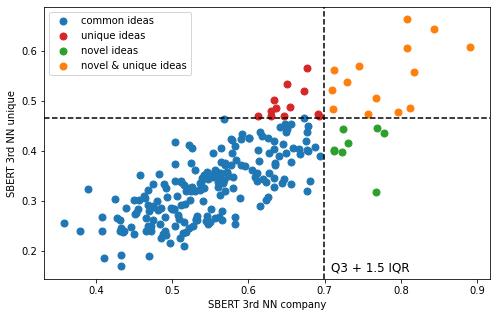

In [38]:
FILE_FIGURE_NOVELTY_OUTLIER = "/content/drive/MyDrive/novelty/novelty_outlier_figure.png"
NOVELTY_SCORE = 'k3_hand_sbert'
OUTLIER_SCORE = 'k3_outlier_sbert'

df = data[[NOVELTY_SCORE, OUTLIER_SCORE]].copy()
df['outlier_novel'] = np.where(iqr_outlier(df[[OUTLIER_SCORE]]) & iqr_outlier(df[[NOVELTY_SCORE]]), 'novel & unique ideas',
              np.where(iqr_outlier(df[[OUTLIER_SCORE]]), 'unique ideas',
              np.where(iqr_outlier(df[[NOVELTY_SCORE]]), 'novel ideas', 'common ideas')))

plt.figure(figsize=(8,5))

groups = df.groupby('outlier_novel')
for name, group in groups:
    plt.plot(group[NOVELTY_SCORE], group[OUTLIER_SCORE], marker='o', linestyle='', markersize=7, label=name)

plt.legend()
plt.axhline(y = iqr_distance(df[[OUTLIER_SCORE]]).item(), color = 'black', linestyle = 'dashed')
plt.axvline(x = iqr_distance(df[[NOVELTY_SCORE]]).item(), color = 'black', linestyle = 'dashed')

plt.xlabel('SBERT 3rd NN company')
plt.ylabel('SBERT 3rd NN unique')

plt.text(0.708, 0.16, 'Q3 + 1.5 IQR', fontsize = 12)
#plt.text(0.77, 0.33, 'Paper Brusher.', fontsize = 10)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 3, 2, 1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig(FILE_FIGURE_NOVELTY_OUTLIER)